In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# Tham số
IMG_SIZE = (144, 256)
BATCH_SIZE = 32
EPOCHS = 30
CLASSNAME = sorted(os.listdir('/kaggle/input/dataset02/dataset_split/train'))
max_words = 5000  # Maximum vocabulary size
max_len = 128  # Fixed sequence length


2025-05-19 03:21:36.314409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747624896.496540      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747624896.550537      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
CLASSNAME

['cleaned', 'defaced']

In [3]:
def load_and_processing_dataset(path):
    data = pd.read_csv(path)
    # Xử lý văn bản
    X = data['HTML Text'].astype(str).values
    y = data['Label'].map({'clean': 0, 'defaced': 1}).values
    tokenizer = Tokenizer(
        num_words=max_words,
        oov_token='<OOV>',
        lower=True,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        split=' '
    )
    tokenizer.fit_on_texts(X)
    X_seq = tokenizer.texts_to_sequences(X)
    X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')
    # Lấy đường dẫn ảnh
    img_paths = data['Image Path'].apply(lambda x: x.replace('\\', '/')).to_list()
    return X_padded, y, img_paths
    
X_train, y_train, train_path = load_and_processing_dataset('/kaggle/input/dataset02/dataset_split/train.csv')
X_val, y_val, val_path = load_and_processing_dataset('/kaggle/input/dataset02/dataset_split/val.csv')
X_test, y_test, test_path = load_and_processing_dataset('/kaggle/input/dataset02/dataset_split/test.csv')


# Check shapes
print(f"Train set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")

# Check class balance
print("Train class distribution:", np.bincount(y_train))
print("Val class distribution:", np.bincount(y_val))
print("Test class distribution:", np.bincount(y_test))

Train set: X_train: (1084, 128), y_train: (1084,)
Validation set: X_val: (232, 128), y_val: (232,)
Test set: X_test: (233, 128), y_test: (233,)
Train class distribution: [529 555]
Val class distribution: [113 119]
Test class distribution: [114 119]


In [4]:
# Load dữ liệu
def load_dataset(path, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory=path,
        labels="inferred",
        label_mode="binary",
        class_names=CLASSNAME,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        interpolation = 'bilinear'        
    )
    normalization_layer = layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    return ds.cache().prefetch(tf.data.AUTOTUNE)

train_ds = load_dataset("/kaggle/input/dataset02/dataset_split/train")
val_ds   = load_dataset("/kaggle/input/dataset02/dataset_split/val")
test_ds  = load_dataset("/kaggle/input/dataset02/dataset_split/test")

Found 1084 files belonging to 2 classes.


I0000 00:00:1747624912.230215      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 232 files belonging to 2 classes.
Found 233 files belonging to 2 classes.


In [5]:
#ResNet50
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(144, 256, 3))

for layer in base_model.layers[:-20]: 
    layer.trainable = False
    
model_resnet50 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
# Compile
model_resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy'])

# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train
model_resnet50.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


I0000 00:00:1747624931.364168     102 service.cc:148] XLA service 0x7a1f68015d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747624931.364811     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747624933.848540     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/34 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5000 - loss: 0.6728 

I0000 00:00:1747624939.671421     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 599ms/step - accuracy: 0.6845 - loss: 0.5922 - val_accuracy: 0.5129 - val_loss: 0.7022
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8373 - loss: 0.3843 - val_accuracy: 0.5129 - val_loss: 0.7015
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8683 - loss: 0.3035 - val_accuracy: 0.5129 - val_loss: 0.6989
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8872 - loss: 0.2589 - val_accuracy: 0.5129 - val_loss: 0.6919
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9252 - loss: 0.2085 - val_accuracy: 0.5302 - val_loss: 0.6793
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9464 - loss: 0.1744 - val_accuracy: 0.5862 - val_loss: 0.6605
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9516 - loss: 0.1495 - val_accuracy: 0.6466 - val_loss: 0.6266
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9697 - loss: 0.1126 - val_accuracy: 0.7198 - val_loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
=== Evaluation on Test Set ===
Precision (macro): 0.8879
Recall (macro):    0.8783
F1-score (macro):  0.8788

Detailed classification report:
              precision    recall  f1-score   support

     cleaned       0.94      0.81      0.87       114
     defaced       0.84      0.95      0.89       119

    accuracy                           0.88       233
   macro avg       0.89      0.88      0.88       233
weighted avg       0.89      0.88      0.88       233



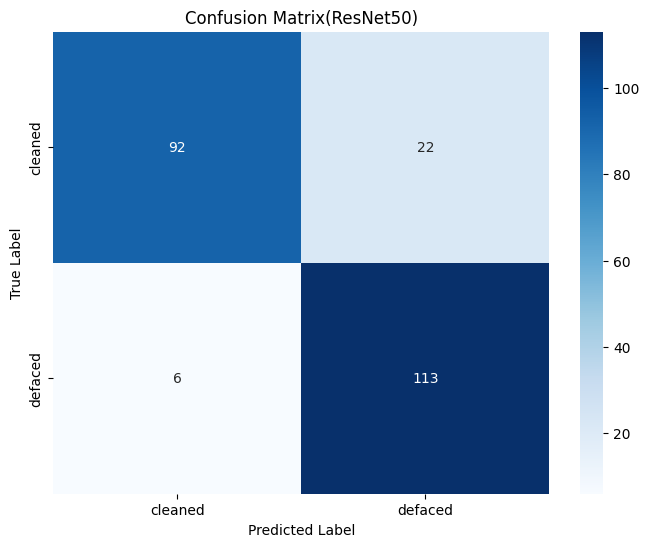

In [6]:
# Đánh giá
true_val, pred_val = [], []
for x, y in test_ds:
    preds = model_resnet50.predict(x)
    preds = (preds > 0.5).astype(int).flatten()
    true_val.extend(y.numpy())
    pred_val.extend(preds)

print("=== Evaluation on Test Set ===")
print(f"Precision (macro): {precision_score(true_val, pred_val, average='macro'):.4f}")
print(f"Recall (macro):    {recall_score(true_val, pred_val, average='macro'):.4f}")
print(f"F1-score (macro):  {f1_score(true_val, pred_val, average='macro'):.4f}")
print("\nDetailed classification report:")
print(classification_report(true_val, pred_val, target_names=CLASSNAME))


# Create and plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(true_val, pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSNAME,
            yticklabels=CLASSNAME)
plt.title('Confusion Matrix(ResNet50)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('CM_ResNet50.png')
plt.show()

In [8]:
model_bilstm = models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False, dropout=0.1)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Huấn luyện BiLSTM
model_bilstm.fit(
    X_train, y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,  # Đảm bảo batch size này giống với ResNet50
    validation_data = (X_val, y_val), 
    callbacks=[early_stopping]
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6883 - loss: 0.5809 - val_accuracy: 0.9095 - val_loss: 0.2693
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9819 - loss: 0.0720 - val_accuracy: 0.8621 - val_loss: 0.3323
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9819 - loss: 0.0396 - val_accuracy: 0.9009 - val_loss: 0.3167
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9923 - loss: 0.0220 - val_accuracy: 0.8448 - val_loss: 0.3955
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Precision (macro): 0.8850
Recall (macro):    0.8836
F1-score (macro):  0.8839

Detailed classification report:
              precision    recall  f1-score   support

     cleaned       0.90      0.86      0.88       114
     defaced       0.87      0.91      0.89       119

    accuracy                           0.88       233
   macro avg       0.89      0.88      0.88       233
weighted avg       0.88      0.88      0.88       233



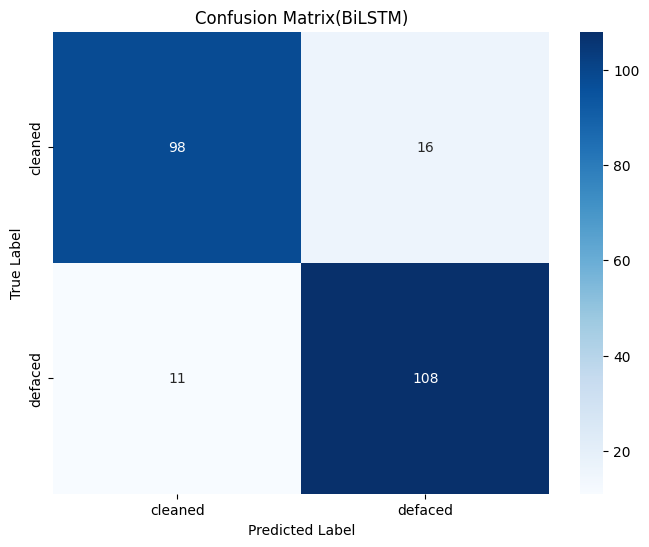

In [9]:
y_pred = model_bilstm.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).flatten()

print(f"Precision (macro): {precision_score(y_test, y_pred, average='macro'):.4f}")
print(f"Recall (macro):    {recall_score(y_test, y_pred, average='macro'):.4f}")
print(f"F1-score (macro):  {f1_score(y_test, y_pred, average='macro'):.4f}")
print("\nDetailed classification report:")
print(classification_report(y_test, y_pred,target_names=CLASSNAME))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSNAME,
            yticklabels=CLASSNAME)
plt.title('Confusion Matrix(BiLSTM)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('CM_BiLSTM.png')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 601ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
=== Soft Voting Fusion Evaluation ===
Precision (macro): 0.9402
Recall (macro):    0.9397
F1-score (macro):  0.9399

Detailed classification report:
              precision    recall  f1-score   support

     cleaned       0.95      0.93      0.94       114
     defaced       0.93      0.95      0.94       119

    accuracy                           0.94       233
   macro avg       0.94      0.94      0.94       233
weighted avg       0.94      0.94      0.94       233



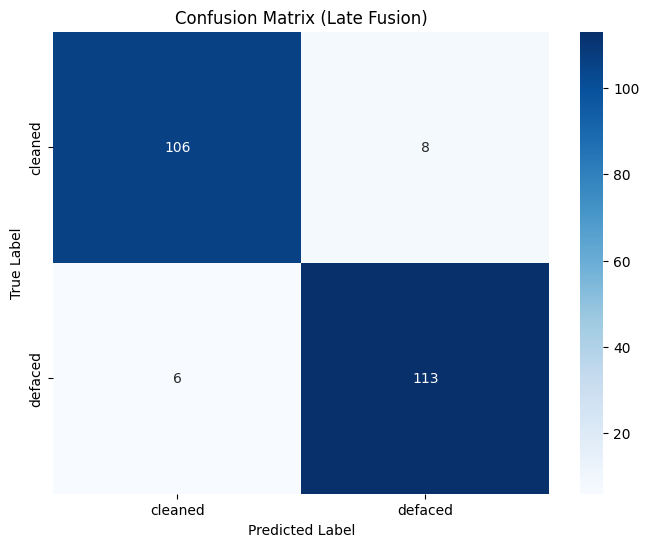

In [10]:
def create_synced_dataset(image_paths, labels, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    images = []
    base_path = "/kaggle/input/dataset02/dataset_split/"  # Tiền tố đường dẫn
    for path in image_paths:
        full_path = os.path.join(base_path, path) if not path.startswith(base_path) else path
        try:
            img = tf.keras.preprocessing.image.load_img(full_path, target_size=img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img_array)
        except FileNotFoundError as e:
            print(f"File not found: {full_path}. Skipping...")
            continue
    if not images:
        raise ValueError("No valid images found in the dataset.")
    images = np.array(images)
    images = images / 255.0  # Chuẩn hóa
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return images, dataset

test_images_synced, test_ds_synced = create_synced_dataset(test_path, y_test)

resnet_probs = model_resnet50.predict(test_ds_synced)  # Xác suất từ ResNet50
bilstm_probs = model_bilstm.predict(X_test)           # Xác suất từ BiLSTM

# Hàm soft voting
def soft_voting(pred_probs_resnet, pred_probs_bilstm, weights=[0.5, 0.5]):
    combined_probs = weights[0] * pred_probs_resnet + weights[1] * pred_probs_bilstm
    final_predictions = (combined_probs > 0.5).astype(int).flatten()
    return final_predictions, combined_probs

# Thực hiện soft voting
final_preds, combined_probs = soft_voting(resnet_probs, bilstm_probs, weights=[0.5, 0.5])

# Đánh giá kết quả
true_labels = y_test
print("=== Soft Voting Fusion Evaluation ===")
print(f"Precision (macro): {precision_score(true_labels, final_preds, average='macro'):.4f}")
print(f"Recall (macro):    {recall_score(true_labels, final_preds, average='macro'):.4f}")
print(f"F1-score (macro):  {f1_score(true_labels, final_preds, average='macro'):.4f}")
print("\nDetailed classification report:")
print(classification_report(true_labels, final_preds, target_names=CLASSNAME))



# Create and plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(true_labels, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSNAME,
            yticklabels=CLASSNAME)
plt.title('Confusion Matrix (Late Fusion)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('CM_LateFusion.png')
plt.show()

In [11]:
model_resnet50.save("ResNet50.h5")
model_bilstm.save('BiLSTM.h5')